# Welcome to the JULO Data Science Take Home Assignment

JULO provides virtual credit limits to it's customers to meet a wide array of customer financing needs. We have provided you with some data related to our customer's loan applications, loan details and their repayment history.

JULO wants to use this data to improve their risk management, and asks you to use your Data Science skills to derive valuable insights from the data and to build a predictive credit score model to aid in future customer credit decisions.

**Requirements:**
1. You have 7 days to report on the assignment
2. Please use python to solve this exercise. You can use libraries such as: sqlalchemy, pandas, or any other packages of your choice that can help you work on the assignments
3. For visualizations, please use python and its common libraries
4. When you are prompted to use sql, please use sqlalchemy for that assignment

**Deliverables:**
1. Python Jupyter notebook with your code (please comment the code! this let us follow your thought process)
2. In addition, also save your notebooks in .html file and attach it with the actual code

**What are we looking for:**
1. Story from the data (Completeness of analysis/ story)
2. There is no right solution to this assignment
3. Your thought process (Be precise, straight to the point, and remember to comment the code)
4. The rationale behind the decisions you made (Provide justifications to your recommendations)

In [1]:
# from google.colab import drive

# drive.mount("/content/drive")

In [2]:
# !pip install optbinning

In [3]:


import numpy as np
import pandas as pd
import sqlalchemy as sa
import seaborn as sns

from datetime import datetime
from matplotlib import pyplot
from optbinning import (
    OptimalBinning,
    ContinuousOptimalBinning,
    Scorecard,
    BinningProcess,
)
from optbinning.scorecard.plots import plot_ks, plot_auc_roc
from pylab import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
    precision_recall_fscore_support,
    ConfusionMatrixDisplay,
)

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
path = 'data/'
# path = "/content/drive/MyDrive/julo/data/"

We have already prepared a database for you to query from

In [5]:
# Create SQL Alchemy Engine
engine = sa.create_engine("sqlite:///database.db")

In [6]:
# Import data as pd.DataFrame
application_df = pd.read_csv(path + "application.csv")
loan_df = pd.read_csv(path + "loan.csv")
payment1_df = pd.read_csv(path + "payment1.csv")
payment2_df = pd.read_csv(path + "payment2.csv")

In [7]:
# Insert data from pd.DataFrame to SQL Alchemy Engine
application_df.to_sql(name="application", con=engine, if_exists="replace")
loan_df.to_sql(name="loan", con=engine, if_exists="replace")
payment1_df.to_sql(name="payment1", con=engine, if_exists="replace")
payment2_df.to_sql(name="payment2", con=engine, if_exists="replace")

In [8]:
def query_from_db(sql_long_string, engine):
    """
    Execute SQL Statement and return the queried data as a pandas.DataFrame object

    :param sql_long_string: SQL statement
    :param engine: SQL Alchemy engine
    """
    statement = engine.execute(sql_long_string)
    df = pd.DataFrame(statement.fetchall())
    df.columns = statement.keys()
    return df


def query_from_db2(sql_long_string, engine):
    """modified"""
    statement = engine.execute(sql_long_string)
    df = pd.DataFrame(statement.fetchall())
    return df

### Assignment 1 - Data Preparation and Cleaning

Please do all these tasks in SQL query.
1. Combine all the tables into a single dataframe.
2. Do you notice anything suspicious with the dataframe? If yes, please do a preliminary analysis and fix it. Explain what you found and how you fix it.
3. Do you see any outliers? Explain how do you detect the outlier and how you fix it.
4. Provide your assumptions on the data.

In [9]:
query_from_db("select * from payment1 limit 1",engine)

,index,Unnamed: 0,Unnamed: 0.1,payment_id,payment_number,due_date,due_amount,paid_date,paid_amount,loan_id,dpd
0,0,0,0,2006021951630,1.0,2021-02-07,0.0,2021-03-08,1026000.0,2.005021e+12,29.0


In [10]:
dfa_query = "select application_id, customer_id, lower(loan_purpose) loan_purpose, lower(loan_purpose_desc) loan_purpose_desc, dob, cdate, lower(address_provinsi) address_provinsi, lower(marital_status) marital_status, dependent, lower(job_type) job_type, lower(job_industry) job_industry from application"
print(dfa_query)
coln='payment_id, payment_number, due_date, due_amount, paid_date, paid_amount, loan_id, dpd'
dfp_query = f"select {coln} from payment1 union select {coln} from payment2"
print(dfp_query)
dfl_query = "select * from loan"
print(dfl_query)

dfa = query_from_db(dfa_query, engine)
dfa.application_id = dfa.application_id.astype("Int64")
dfa.cdate = pd.to_datetime(dfa.cdate.str[:-6])
dfa.dob = pd.to_datetime(dfa.dob)
dfa["age"] = (dfa.cdate - dfa.dob).dt.days / 365

dfp = query_from_db(dfp_query, engine)
dfp.payment_id = dfp.payment_id.astype("Int64")

dfl = query_from_db(dfl_query, engine)
dfl.loan_id = dfl.loan_id.astype("Int64")
dfl.application_id = dfl.application_id.astype("Int64")

select application_id, customer_id, lower(loan_purpose) loan_purpose, lower(loan_purpose_desc) loan_purpose_desc, dob, cdate, lower(address_provinsi) address_provinsi, lower(marital_status) marital_status, dependent, lower(job_type) job_type, lower(job_industry) job_industry from application
select payment_id, payment_number, due_date, due_amount, paid_date, paid_amount, loan_id, dpd from payment1 union select payment_id, payment_number, due_date, due_amount, paid_date, paid_amount, loan_id, dpd from payment2
select * from loan


#### \1. Combine all tables into a single dataframe

In [11]:
dfsingle = query_from_db(
    f"""
WITH payment as (select {coln} FROM payment1 WHERE dpd IS NOT NULL union select {coln} FROM payment2 WHERE dpd IS NOT NULL)

SELECT cdate, application_id, customer_id, loan_purpose, loan_purpose_desc, dob, address_provinsi, marital_status, dependent, job_type, job_industry, loan_id, loan_amount, loan_duration, installment_amount, fund_transfer_ts, payment_id, payment_number, due_date, due_amount, paid_date, paid_amount, dpd
FROM application left join loan using(application_id) left join payment using(loan_id)
""",
    engine,
)
dfsingle

,cdate,application_id,customer_id,loan_purpose,loan_purpose_desc,dob,address_provinsi,marital_status,dependent,job_type,...,loan_duration,installment_amount,fund_transfer_ts,payment_id,payment_number,due_date,due_amount,paid_date,paid_amount,dpd
0,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,1.0,2021-03-02,0.0,2021-04-02,149000.0,31.0
1,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,2.0,2021-04-02,0.0,2021-05-16,195000.0,44.0
2,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,3.0,2021-05-02,NaN,2021-05-30,140000.0,28.0
3,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,4.0,2021-06-02,0.0,2021-07-06,140000.0,34.0
4,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,...,5.0,154000.0,2021-07-19 11:49:50.894052+00:00,2.006023e+12,1.0,2021-09-01,0.0,2021-10-06,181700.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11947,2021-03-24 05:31:55.764238+00:00,2004026221387,2.003024e+12,Kebutuhan sehari-hari,"untuk tambahan nikah, dan kebutuhan sehari har...",1997-09-22,None,Lajang,0.0,Pegawai swasta,...,4.0,150000.0,2021-11-27 10:24:44.448152+00:00,2.006037e+12,3.0,2022-02-28,0.0,2022-03-06,150000.0,6.0
11948,2021-03-24 05:31:55.764238+00:00,2004026221387,2.003024e+12,Kebutuhan sehari-hari,"untuk tambahan nikah, dan kebutuhan sehari har...",1997-09-22,None,Lajang,0.0,Pegawai swasta,...,1.0,56167.0,2021-12-24 13:08:58.970547+00:00,2.006044e+12,1.0,2022-01-30,0.0,2022-03-01,56167.0,30.0
11949,2021-03-24 05:31:55.764238+00:00,2004026221387,2.003024e+12,Kebutuhan sehari-hari,"untuk tambahan nikah, dan kebutuhan sehari har...",1997-09-22,None,Lajang,0.0,Pegawai swasta,...,3.0,42000.0,2022-01-09 02:29:18.134687+00:00,2.006048e+12,1.0,2022-02-28,0.0,2022-03-06,45000.0,6.0
11950,2021-03-24 05:31:55.764238+00:00,2004026221387,2.003024e+12,Kebutuhan sehari-hari,"untuk tambahan nikah, dan kebutuhan sehari har...",1997-09-22,None,Lajang,0.0,Pegawai swasta,...,4.0,95000.0,2022-02-01 01:35:34.133097+00:00,NaN,NaN,None,NaN,None,NaN,NaN


#### \2. suspicious with the dataframe

- payment1 & payment2 are identical

In [12]:
query_from_db2("""SELECT * FROM payment2 EXCEPT SELECT * FROM payment1""", engine)

""


- some dpd and paid_date are nan, so we cannot know if the users pay late or not
- some loan_amount are nan
- text input have different cases, so lowercasing is important

#### \3. outliers

(in python) Here we define outliers as observations that fall below Q1 − 1.5 IQR or above Q3 + 1.5 IQR

In [13]:
dfdesc=dfsingle[dfsingle.columns[~dfsingle.columns.str.endswith("_id")]].describe(
    percentiles=[0.25, 0.5, 0.75]
).T

dfdesc['IQR']=dfdesc['75%']-dfdesc['25%']
dfdesc['lower_bound']=dfdesc['25%']-1.5*dfdesc['IQR']
dfdesc['upper_bound']=dfdesc['75%']+1.5*dfdesc['IQR']

dfdesc

,count,mean,std,min,25%,50%,75%,max,IQR,lower_bound,upper_bound
dependent,10570.0,1.093661e+00,1.110222e+00,0.0,0.00,1.0,2.00,5.0,2.00,-3.000,5.000
loan_amount,11720.0,1.444976e+06,2.104330e+06,8061.0,300000.00,527263.0,1722236.75,18000000.0,1422236.75,-1833355.125,3855591.875
loan_duration,11700.0,4.395983e+00,2.235713e+00,1.0,3.00,4.0,6.00,9.0,3.00,-1.500,10.500
installment_amount,11673.0,3.492053e+05,4.166504e+05,8888.0,102000.00,177000.0,450000.00,3360000.0,348000.00,-420000.000,972000.000
payment_number,10995.0,2.452933e+00,1.598343e+00,1.0,1.00,2.0,3.00,9.0,2.00,-2.000,6.000
due_amount,10992.0,2.184610e+03,5.166050e+04,-535300.0,0.00,0.0,0.00,2545000.0,0.00,0.000,0.000
paid_amount,10972.0,3.544355e+05,4.194594e+05,374.0,105893.25,187000.0,453000.00,3776000.0,347106.75,-414766.875,973660.125
dpd,11205.0,1.178394e+01,3.317560e+01,-230.0,6.00,26.0,29.00,236.0,23.00,-28.500,63.500


For example for loan_amount

In [14]:
dfsingle.query('loan_amount>3855591.875').head()

,cdate,application_id,customer_id,loan_purpose,loan_purpose_desc,dob,address_provinsi,marital_status,dependent,job_type,...,loan_duration,installment_amount,fund_transfer_ts,payment_id,payment_number,due_date,due_amount,paid_date,paid_amount,dpd
18,2021-02-07 05:21:46.225530+00:00,2004025885365,2.003023e+12,Kebutuhan sehari-hari,banyak pengeluaran bulan ini jadi ngk ketutup ...,None,None,Lajang,0.0,Pegawai swasta,...,9.0,2053000.0,2021-02-08 02:50:18.311835+00:00,2.006022e+12,1.0,2021-03-03,0.0,2021-03-30,1885000.0,27.0
19,2021-02-07 05:21:46.225530+00:00,2004025885365,2.003023e+12,Kebutuhan sehari-hari,banyak pengeluaran bulan ini jadi ngk ketutup ...,None,None,Lajang,0.0,Pegawai swasta,...,9.0,2053000.0,2021-02-08 02:50:18.311835+00:00,2.006022e+12,2.0,2021-04-03,0.0,2021-05-13,2155700.0,40.0
20,2021-02-07 05:21:46.225530+00:00,2004025885365,2.003023e+12,Kebutuhan sehari-hari,banyak pengeluaran bulan ini jadi ngk ketutup ...,None,None,Lajang,0.0,Pegawai swasta,...,9.0,2053000.0,2021-02-08 02:50:18.311835+00:00,2.006022e+12,3.0,2021-05-03,0.0,2021-07-28,2258400.0,86.0
21,2021-02-07 05:21:46.225530+00:00,2004025885365,2.003023e+12,Kebutuhan sehari-hari,banyak pengeluaran bulan ini jadi ngk ketutup ...,None,None,Lajang,0.0,Pegawai swasta,...,9.0,2053000.0,2021-02-08 02:50:18.311835+00:00,2.006022e+12,4.0,2021-06-03,0.0,2021-07-28,NaN,55.0
22,2021-02-07 05:21:46.225530+00:00,2004025885365,2.003023e+12,Kebutuhan sehari-hari,banyak pengeluaran bulan ini jadi ngk ketutup ...,None,None,Lajang,0.0,Pegawai swasta,...,9.0,2053000.0,2021-02-08 02:50:18.311835+00:00,2.006022e+12,5.0,2021-07-03,2271900.0,2021-09-26,500000.0,85.0


#### \4. fix

While outlier by the above definitions exists, I decide to leave the data as-is because dropping/fixing data carelessly may further damage the data

For sure, I will remove NULL/NaN values such as null DPD, because we cannot analyze null DPDs

### Assignment 2 - Label analysis

Please do all these analysis in SQL query.
1. We don't want to give credit to `bad` customers (customers that don't pay at all). Can you define what a `bad` customers is from the dataset provided and what is the earliest indicator to say that a customer is `bad`?
2. Based on the label that you defined, what kind of trends do you see in the data that distinguish good and bad customers?
3. Arrange customers by “loan amount” in ascending order and provide cumulative default rates by equal-sized deciles. Each decile should have:
> a. Number of loans <br>
> b. Number of defaulted loans <br>
> c. The default rate for each decile <br>
> d. Cumulative default rate <br>
> e. Min, max, avg “loan amount” <br>

#### \1. Definition of bad customer

Here I defined bad customer is defined as people who still have due_amount after DPD+30 days, including people who do not pay at all

#### \2.Trends that distinguish good and bad customers?

I distinguish customers based on whether they have due_amount after DPD+30 days

#### \3. Arrange customers by “loan amount” in ascending orde
provided below in SQL

a. Number of loans  
b. Number of defaulted loans  
d. Cumulative default rate  
e. Min, max, avg “loan amount”  

In [21]:
the_query = """
WITH
 dfa AS (SELECT application_id, customer_id, lower(loan_purpose) loan_purpose, lower(loan_purpose_desc) loan_purpose_desc, dob, cdate, lower(address_provinsi) address_provinsi, lower(marital_status) marital_status, dependent, lower(job_type) job_type, lower(job_industry) job_industry FROM application)
,dfl AS (SELECT * FROM loan)
,dfp AS (SELECT payment_id, payment_number, due_date, due_amount, paid_date, paid_amount, loan_id, dpd FROM payment1 union SELECT payment_id, payment_number, due_date, due_amount, paid_date, paid_amount, loan_id, dpd FROM payment2)
,dfpnn AS (SELECT* FROM dfp where dpd IS NOT NULL)
,dfp_blm_lunas AS (SELECT cASe when due_amount > 0 AND dpd > 30 then 1 else 0 end AS _blm_lunas,* FROM dfpnn)
,dfp_default AS (SELECT _blm_lunas AS defaul, * FROM dfp_blm_lunas)


,dfl3 AS (
SELECT
 *
, CASE when sum(_blm_lunas) > 0 then 1 else 0 end defaul 
FROM dfl
LEFT JOIN dfp_blm_lunas USING(loan_id) 
WHERE _blm_lunas IS NOT NULL
GROUP BY loan_id
)

, dfuser_pre AS (
SELECT
    customer_id
    , sum(loan_amount) total_loan 
    , count(COALESCE(loan_amount,0)) num_loan
    , sum(defaul) num_default_loan 
    , min(loan_amount) min_loan
    , max(loan_amount) max_loan
    , avg(loan_amount) avg_loan
FROM 
    (SELECT application_id, customer_id FROM dfa) a
left join 
    dfl3 b 
    on a.application_id = b.application_id
group by 1
having min(loan_amount) > 0 
)

, dfuser_pre2 AS (
SELECT 
    customer_id 
    , coalesce(total_loan,0) total_loan
    , coalesce(num_loan,0) num_loan
    , coalesce(num_default_loan,0) num_default_loan
    , coalesce(min_loan,0) min_loan
    , coalesce(max_loan,0) max_loan
    , coalesce(avg_loan,0) avg_loan
    , num_default_loan * 1.000 / num_loan defaulT_rate
    , row_number() over(order by total_loan) rn
FROM 
    dfuser_pre
order by 2,1 ASc 
)

, dfuser AS (
SELECT 
    *
    , sum(default_rate) over(order by rn) / count(customer_id) over(order by rn) cum_default_rate
FROM 
    dfuser_pre2
)


SELECT * FROM dfuser where customer_id IS NOT NULL
"""

the_query = q = """
WITH
 dfa AS (SELECT application_id, customer_id, lower(loan_purpose) loan_purpose, lower(loan_purpose_desc) loan_purpose_desc, dob, cdate, lower(address_provinsi) address_provinsi, lower(marital_status) marital_status, dependent, lower(job_type) job_type, lower(job_industry) job_industry FROM application)
,dfl AS (SELECT * FROM loan)
,dfp AS (SELECT payment_id, payment_number, due_date, due_amount, paid_date, paid_amount, loan_id, dpd FROM payment1 )
,dfpnn AS (SELECT* FROM dfp where dpd IS NOT NULL)
,dfp_default AS (
    SELECT loan_id,
    CASE WHEN SUM(paid_amount)=0 THEN 1 ELSE 0 END AS 'defaul'
    FROM dfp
    GROUP BY loan_id
)

,dfl3 AS (
SELECT *
FROM dfl
LEFT JOIN dfp_default USING(loan_id) 
-- WHERE defaul IS NOT NULL
GROUP BY loan_id
)

, dfuser_pre AS (
SELECT
    customer_id
    , sum(loan_amount) total_loan 
    , count(COALESCE(loan_amount,0)) num_loan
    , sum(defaul) num_default_loan 
    , min(loan_amount) min_loan
    , max(loan_amount) max_loan
    , avg(loan_amount) avg_loan
FROM 
    (SELECT application_id, customer_id FROM dfa) a
left join 
    dfl3 b 
    on a.application_id = b.application_id
group by 1
having min(loan_amount) > 0 
)

, dfuser_pre2 AS (
SELECT 
    customer_id 
    , coalesce(total_loan,0) total_loan
    , coalesce(num_loan,0) num_loan
    , coalesce(num_default_loan,0) num_default_loan
    , coalesce(min_loan,0) min_loan
    , coalesce(max_loan,0) max_loan
    , coalesce(avg_loan,0) avg_loan
    , num_default_loan * 1.000 / num_loan customer_default_rate
    , row_number() over(order by total_loan) rn
FROM 
    dfuser_pre
order by 2,1 ASc 
)

, dfuser AS (
SELECT 
    *
    , sum(customer_default_rate) over(order by rn) / count(customer_id) over(order by rn) cum_default_rate
FROM 
    dfuser_pre2
)


SELECT * FROM dfuser
WHERE customer_id IS NOT NULL
"""

# print(the_query)
dfuser=query_from_db(the_query, engine)
dfuser

,customer_id,total_loan,num_loan,num_default_loan,min_loan,max_loan,avg_loan,customer_default_rate,rn,cum_default_rate
0,2.003024e+12,31042.0,1,1,31042.0,31042.0,3.104200e+04,1.000000,1,1.000000
1,2.003024e+12,96096.0,6,6,10453.0,21579.0,1.601600e+04,1.000000,2,1.000000
2,2.003024e+12,105860.0,1,1,105860.0,105860.0,1.058600e+05,1.000000,3,1.000000
3,2.003025e+12,132338.0,2,2,26478.0,105860.0,6.616900e+04,1.000000,4,1.000000
4,2.003025e+12,147660.0,4,3,15695.0,52905.0,3.691500e+04,0.750000,5,0.950000
...,...,...,...,...,...,...,...,...,...,...
444,2.003022e+12,40500000.0,5,0,5000000.0,12000000.0,8.100000e+06,0.000000,445,0.155005
445,2.003021e+12,44564985.0,547,2,21421.0,1053000.0,8.268086e+04,0.003656,446,0.154665
446,2.003025e+12,58793106.0,108,15,31893.0,1053789.0,5.546519e+05,0.138889,447,0.154630
447,2.003024e+12,77000000.0,23,2,1000000.0,12000000.0,3.347826e+06,0.086957,448,0.154479


In [34]:
dfuser2 = dfuser.drop(columns=['customer_id','cum_default_rate','rn','num_default_loan'])
corr=dfuser2.corr()
corr.style.background_gradient(cmap='coolwarm')

,total_loan,num_loan,min_loan,max_loan,avg_loan,customer_default_rate
total_loan,1.000000,0.366450,0.074899,0.600288,0.322306,-0.235204
num_loan,0.366450,1.000000,-0.144736,-0.094188,-0.174303,-0.058907
min_loan,0.074899,-0.144736,1.000000,0.511868,0.868927,-0.123077
max_loan,0.600288,-0.094188,0.511868,1.000000,0.806288,-0.257081
avg_loan,0.322306,-0.174303,0.868927,0.806288,1.000000,-0.206074
customer_default_rate,-0.235204,-0.058907,-0.123077,-0.257081,-0.206074,1.000000


In [55]:
# sns.pairplot(dfuser2, kind="reg")

In [56]:
dfuser2['default']=np.where(dfuser2.customer_default_rate>0,1,0)

In [57]:
def kdebarplotlog(df_: pd.DataFrame, colx: str, coly: str = "default"):
    # plt.figure(figsize=(16, 3))
    fig, axes = plt.subplots(1, 4)
    fig.set_figheight(5)
    fig.set_figwidth(16)
    sns.kdeplot((df_[colx]), hue=df_[coly], common_norm=False, ax=axes[0])
    sns.kdeplot(np.log10(df_[colx]), hue=df_[coly], common_norm=False, ax=axes[1])
    sns.boxplot(y=(df_[colx]), x=df_[coly], ax=axes[2])
    sns.boxplot(y=np.log10(df_[colx]), x=df_[coly], ax=axes[3])

In [66]:
# sns.lmplot(x="total_loan", y="customer_default_rate", hue="default", data=dfuser2);

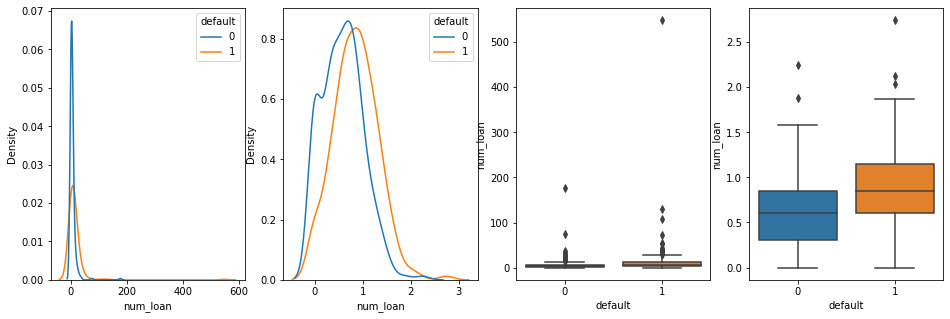

In [58]:
kdebarplotlog(dfuser2, "num_loan")

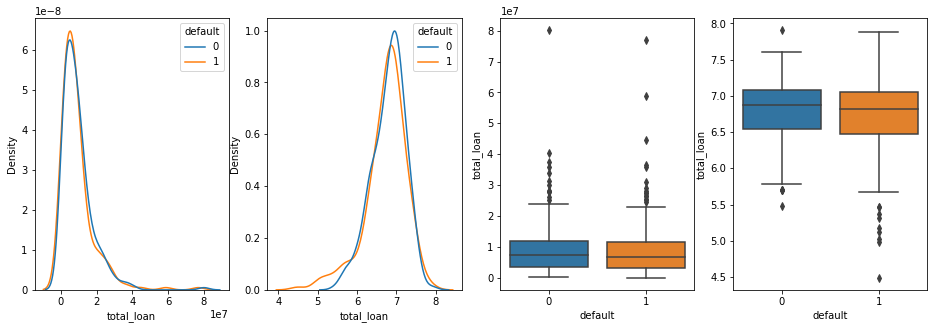

In [59]:
kdebarplotlog(dfuser2, "total_loan")

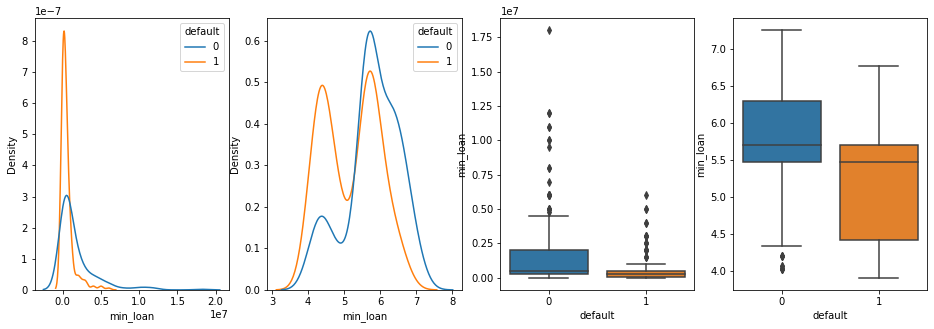

In [60]:
kdebarplotlog(dfuser2, "min_loan")

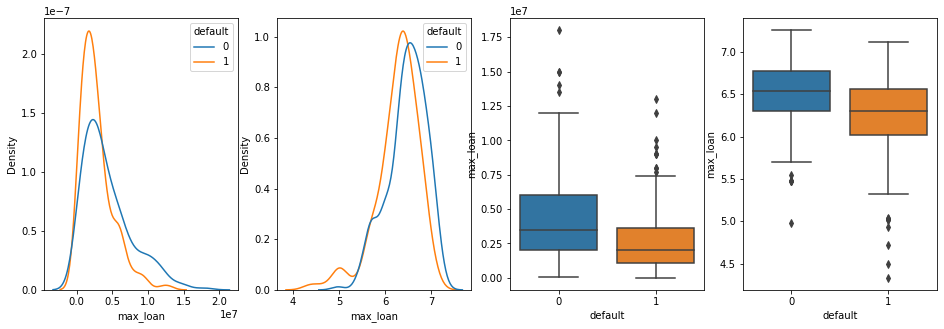

In [61]:
kdebarplotlog(dfuser2, "max_loan")

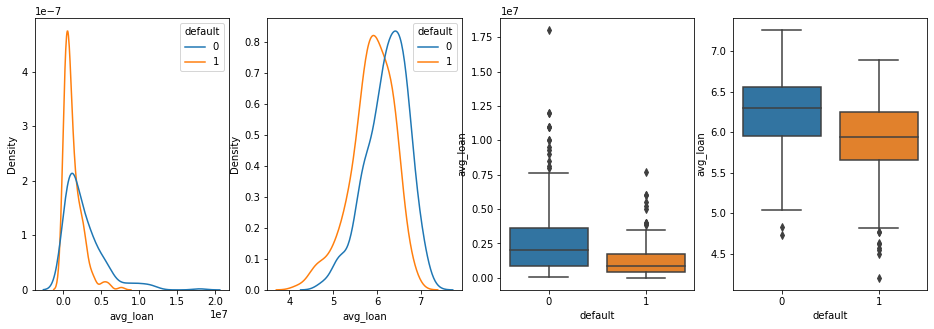

In [62]:
kdebarplotlog(dfuser2, "avg_loan")

For 3c, I provide in python

c. The default rate for each decile

In [16]:
dfuser["default_rate"] = dfuser.num_default_loan / dfuser.num_loan

# dfuser["cum_default_rate"] = dfuser["default_rate"].expanding().mean()

dfuser["bin"] = pd.qcut(dfuser.total_loan, 10)
dfuser = dfuser.reset_index()
dfuser = dfuser.set_index("bin")
dfuser["default_rate_decile"] = dfuser.groupby("bin").default_rate.mean()
dfuser = dfuser.reset_index()
dfuser.customer_id = dfuser.customer_id.astype("Int64")

dfuser

,bin,index,customer_id,total_loan,num_loan,num_default_loan,min_loan,max_loan,avg_loan,defaulT_rate,rn,cum_default_rate,default_rate,default_rate_decile
0,"(31041.999, 1500000.0]",0,2003024012956,31042.0,1,1,31042.0,31042.0,3.104200e+04,1.000000,1,1.000000,1.000000,0.397708
1,"(31041.999, 1500000.0]",1,2003023894338,96096.0,6,6,10453.0,21579.0,1.601600e+04,1.000000,2,1.000000,1.000000,0.397708
2,"(31041.999, 1500000.0]",2,2003023593505,105860.0,1,1,105860.0,105860.0,1.058600e+05,1.000000,3,1.000000,1.000000,0.397708
3,"(31041.999, 1500000.0]",3,2003024976942,132338.0,2,2,26478.0,105860.0,6.616900e+04,1.000000,4,1.000000,1.000000,0.397708
4,"(31041.999, 1500000.0]",4,2003024588958,147660.0,4,3,15695.0,52905.0,3.691500e+04,0.750000,5,0.950000,0.750000,0.397708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,"(20500000.0, 80109801.0]",444,2003021661444,40500000.0,5,0,5000000.0,12000000.0,8.100000e+06,0.000000,445,0.155005,0.000000,0.059864
445,"(20500000.0, 80109801.0]",445,2003020680474,44564985.0,547,2,21421.0,1053000.0,8.268086e+04,0.003656,446,0.154665,0.003656,0.059864
446,"(20500000.0, 80109801.0]",446,2003024539617,58793106.0,108,15,31893.0,1053789.0,5.546519e+05,0.138889,447,0.154630,0.138889,0.059864
447,"(20500000.0, 80109801.0]",447,2003023748842,77000000.0,23,2,1000000.0,12000000.0,3.347826e+06,0.086957,448,0.154479,0.086957,0.059864


### Assignment 3 - Feature Engineering

Based on your findings in Assignment 2, please create features using SQL that you think could be predictive for a machine learning model.

In [18]:
the_query = """
WITH
 dfa AS (SELECT application_id, customer_id, lower(loan_purpose) loan_purpose, lower(loan_purpose_desc) loan_purpose_desc, dob, cdate, lower(address_provinsi) address_provinsi, lower(marital_status) marital_status, dependent, lower(job_type) job_type, lower(job_industry) job_industry FROM application)
,dfl AS (SELECT * FROM loan)
,dfp AS (SELECT payment_id, payment_number, due_date, due_amount, paid_date, paid_amount, loan_id, dpd FROM payment1 union SELECT payment_id, payment_number, due_date, due_amount, paid_date, paid_amount, loan_id, dpd FROM payment2)
,dfpnn AS (SELECT* FROM dfp where dpd IS NOT NULL)
,dfp_blm_lunas AS (SELECT cASe when due_amount > 0 AND dpd > 30 then 1 else 0 end AS _blm_lunas,* FROM dfpnn)
,dfp_default AS (SELECT _blm_lunas AS defaul, * FROM dfp_blm_lunas)


,dfl3 AS (
SELECT *, CASE when sum(_blm_lunas) > 0 then 1 else 0 end defaul 
FROM dfl
LEFT JOIN dfp_blm_lunas USING(loan_id) 
WHERE _blm_lunas IS NOT NULL
GROUP BY loan_id
)
,dfl4 AS (
SELECT application_id, avg(loan_amount) loan_amount, sum(defaul) defaul 
FROM dfl3 
group by 1
)
, dfnew AS (
SELECT a.*, b.*
FROM (SELECT * FROM dfa) a 
left join dfl4 b USING(application_id)
)

SELECT application_id,customer_id,loan_purpose,dob,cdate,address_provinsi,marital_status,dependent,job_type,job_industry,loan_amount,defaul 'default' FROM dfnew
WHERE loan_amount IS NOT NULL
"""
# print(the_query)
dfnew=query_from_db(the_query, engine)

# Typecasting

dfnew.customer_id=dfnew.customer_id.astype("Int64")
dfnew.dob=pd.to_datetime(dfnew.dob)
dfnew.cdate=pd.to_datetime(dfnew.cdate.str[:-6])
dfnew["loan_amount"] = np.floor(dfnew["loan_amount"]).astype('int')
dfnew["age"] = np.floor((dfnew.cdate - dfnew.dob).dt.days / 365).astype('Int64')
dfnew.default=dfnew.default.astype(bool).astype(int)
dfnew

,application_id,customer_id,loan_purpose,dob,cdate,address_provinsi,marital_status,dependent,job_type,job_industry,loan_amount,default,age
0,2004025695250,2003023548799,modal usaha,2000-01-06,2021-01-07 13:45:43.876693,banten,lajang,1.0,pegawai swasta,admin / finance / hr,466666,0,21
1,2004025736661,2003023567116,modal usaha,1986-07-22,2021-01-14 15:56:27.403268,banten,menikah,2.0,pegawai swasta,admin / finance / hr,1750000,0,34
2,2004025885365,2003023442469,kebutuhan sehari-hari,NaT,2021-02-07 05:21:46.225530,None,lajang,0.0,pegawai swasta,pabrik / gudang,12000000,1,<NA>
3,2004026435734,2003023912156,modal usaha,1996-01-16,2021-04-22 07:15:09.482447,jawa barat,menikah,1.0,pegawai swasta,pabrik / gudang,1666666,0,25
4,2004025890269,2003023639117,renovasi rumah,1992-06-13,2021-02-07 14:57:21.120284,None,None,0.0,pegawai swasta,sales / marketing,8000000,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2004025950383,2003023667607,renovasi rumah,1972-05-14,2021-02-16 09:14:30.426871,jawa barat,menikah,3.0,pengusaha,transportasi,2500000,0,48
464,2004026541054,2003023971833,kebutuhan sehari-hari,1994-02-05,2021-05-06 04:04:23.798351,jawa barat,menikah,0.0,pegawai swasta,service,888226,0,27
465,2004026770549,2003023874771,kebutuhan sehari-hari,1992-04-11,2021-06-09 02:39:48.937232,jawa barat,None,0.0,pegawai swasta,hukum / security / politik,600000,0,29
466,2004026118497,2003023752181,biaya kesehatan,1999-10-29,2021-03-11 03:39:05.688931,jawa barat,lajang,0.0,pegawai swasta,tehnik / computer,471033,0,21


### Assignment 4 - Data Visualization
Using the features you engineered in Assignment 3, could you visualize the data to show a business user that your features are useful?

In [51]:
def kdebarplotlog(df_: pd.DataFrame, colx: str, coly: str = "default"):
    # plt.figure(figsize=(16, 3))
    fig, axes = plt.subplots(1, 4)
    fig.set_figheight(5)
    fig.set_figwidth(16)
    sns.kdeplot((df_[colx]), hue=df_[coly], common_norm=False, ax=axes[0])
    sns.kdeplot(np.log10(df_[colx]), hue=df_[coly], common_norm=False, ax=axes[1])
    sns.boxplot(y=(df_[colx]), x=df_[coly], ax=axes[2])
    sns.boxplot(y=np.log10(df_[colx]), x=df_[coly], ax=axes[3])

I will use barplot and kdeplot to show the usefulness of my features. The first plot will be in real scale and the second plot will be in log10 scale. I will show the mean difference between non-defaulters and defaulters

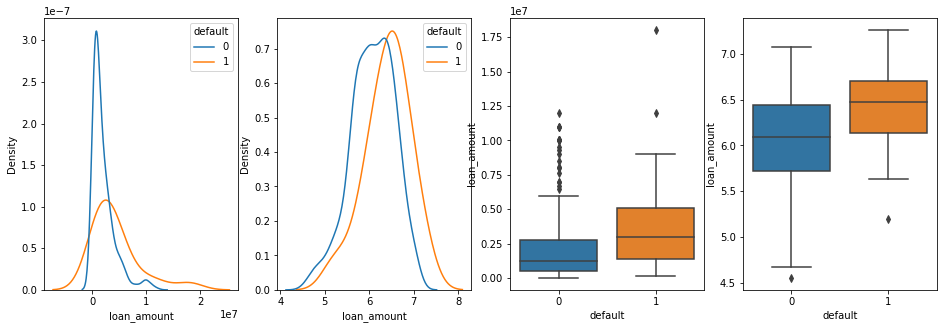

In [20]:
kdebarplotlog(dfnew, "loan_amount")

We see that on average most of non-defaulters borrows on less than 250k IDR and defaulters borrows more than 250k IDR

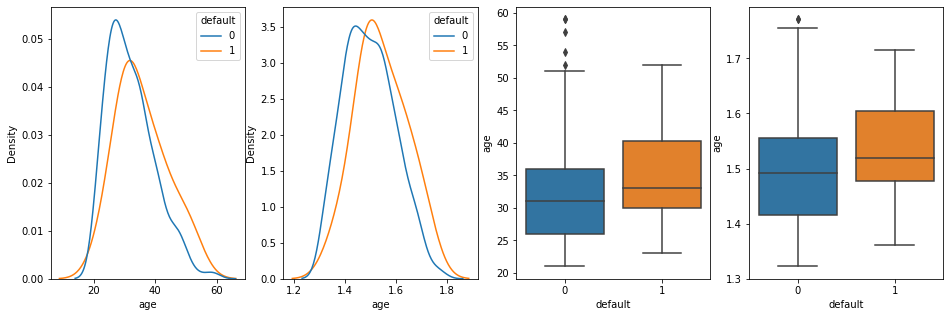

In [21]:
kdebarplotlog(dfnew, "age")

We see that most of non-defaulters are younger than the defaulters

d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
d:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
d:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))


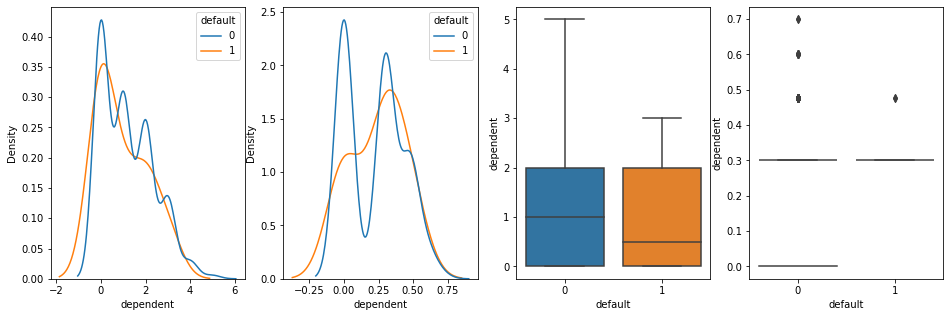

In [22]:
kdebarplotlog(dfnew, "dependent")

We see non-defaulters has more dependants than the defaulters

### Assignment 5 - Modeling

#### \1. Please build model(s) using the label and features that you have developed.

Provided below

In [23]:

def df_summarier(df, percentiles=[0.25, 0.5, 0.75]) -> pd.DataFrame:
    a = df.isna().any(axis=0)
    notnan = df.count()
    b = df.dtypes
    c = df.nunique()
    d = pd.Series({col: df[col].unique() for col in df})
    print("df.shape", df.shape)
    # print("df.created_time.min()", df.created_time.min(), "df.created_time.max()", df.created_time.max(), )
    print("df summary")
    return pd.concat(
        [a, notnan, b, c, d, df.describe(percentiles=percentiles).T], axis=1
    ).rename(
        columns={
            0: "has nan?",
            1: "num of notnan",
            2: "dtypes",
            3: "num of unique values",
            4: "list of unique values",
        }
    )


def create_binning_config(df_: pd.DataFrame, force_monotonic: bool = False) -> dict:
    bfp = {}
    for col in df_.columns:
        if col == "TARGET":
            continue
        dtype = "numerical"
        solver = "cp"
        if df_[col].dtype == object:
            dtype = "categorical"
            # solver="mip"
        name = col

        if force_monotonic:
            bfp[name] = {
                "dtype": dtype,
                "solver": solver,
                "monotonic_trend": "auto_asc_desc",
            }
        else:
            bfp[name] = {"dtype": dtype, "solver": solver}

    return bfp


def predictiveness(i: float) -> str:
    if i < 0.02:
        return "Not useful for prediction"
    if 0.02 < i <= 0.1:
        return "Weak predictive Power"
    if 0.1 < i <= 0.3:
        return "Medium predictive Power"
    if 0.3 < i <= 0.5:
        return "Strong predictive Power"
    if i > 0.5:
        return "Suspicious Predictive Power"


def create_binning(
    df_: pd.DataFrame,
    binning_fit_params: dict,
    target="TARGET",
    list_features=None,
    special_codes=[],
    plot=True,
) -> BinningProcess:
    print("tes tes")
    # 1) Define list of features and categorical ones
    if list_features is None:
        list_features = df_.drop(columns=[target]).columns.values
    print(f"list_features={list_features}")
    list_categorical = df_.select_dtypes(include=["object", "category"]).columns.values
    # 2) Instantiate BinningProcess
    binning_process = BinningProcess(
        categorical_variables=list_categorical,
        variable_names=list_features,
        binning_fit_params=binning_fit_params,
        special_codes=special_codes,
    )

    # 3) Fit and transform dataset
    binning_process.fit(df_.drop(columns=[target]), df_[target])

    for col in binning_process.variable_names:
        optb = binning_process.get_binned_variable(col)
        optb.binning_table.build()
        if plot:
            print(col)
            optb.binning_table.plot(metric="woe")
            display(optb.binning_table.build())
            display(optb.binning_table.build().Bin.values.tolist())

            print("==")

    return binning_process


def get_iv(binning_process: BinningProcess) -> pd.DataFrame:
    ll = []

    for col in binning_process.variable_names:
        optb = binning_process.get_binned_variable(col)
        # optb.binning_table.plot(metric="woe")
        iv = optb.binning_table.build().IV.Totals
        ll.append({"column": col, "IV": iv})

    dfiv = pd.DataFrame(ll).sort_values("IV", ascending=False)
    dfiv["predictiveness"] = dfiv.IV.apply(predictiveness)
    return dfiv


def get_class_weight(df_, target="default"):
    cw0full = df_.groupby(target).count().T.iloc[0]
    class_weightfull = (1 - (cw0full / df_.shape[0])).to_dict()
    return class_weightfull

In [24]:
bfp = create_binning_config(dfnew)
bfp

{'application_id': {'dtype': 'numerical', 'solver': 'cp'},
 'customer_id': {'dtype': 'numerical', 'solver': 'cp'},
 'loan_purpose': {'dtype': 'categorical', 'solver': 'cp'},
 'dob': {'dtype': 'numerical', 'solver': 'cp'},
 'cdate': {'dtype': 'numerical', 'solver': 'cp'},
 'address_provinsi': {'dtype': 'categorical', 'solver': 'cp'},
 'marital_status': {'dtype': 'categorical', 'solver': 'cp'},
 'dependent': {'dtype': 'numerical', 'solver': 'cp'},
 'job_type': {'dtype': 'categorical', 'solver': 'cp'},
 'job_industry': {'dtype': 'categorical', 'solver': 'cp'},
 'loan_amount': {'dtype': 'numerical', 'solver': 'cp'},
 'default': {'dtype': 'numerical', 'solver': 'cp'},
 'age': {'dtype': 'numerical', 'solver': 'cp'}}

In [25]:
dfnew.default.value_counts()

0    449
1     19
Name: default, dtype: int64

In [26]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(dfnew, stratify=dfnew.default)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

In [27]:
print(dfnew.default.value_counts())
print(dfnew.default.value_counts(normalize=True))

0    449
1     19
Name: default, dtype: int64
0    0.959402
1    0.040598
Name: default, dtype: float64


In [28]:
# train

In [29]:
bfp["age"]["monotonic_trend"] = "auto_asc_desc"
bfp["dependent"]["monotonic_trend"] = "ascending"
bfp["loan_amount"]["monotonic_trend"] = "ascending"
bfp

{'application_id': {'dtype': 'numerical', 'solver': 'cp'},
 'customer_id': {'dtype': 'numerical', 'solver': 'cp'},
 'loan_purpose': {'dtype': 'categorical', 'solver': 'cp'},
 'dob': {'dtype': 'numerical', 'solver': 'cp'},
 'cdate': {'dtype': 'numerical', 'solver': 'cp'},
 'address_provinsi': {'dtype': 'categorical', 'solver': 'cp'},
 'marital_status': {'dtype': 'categorical', 'solver': 'cp'},
 'dependent': {'dtype': 'numerical',
  'solver': 'cp',
  'monotonic_trend': 'ascending'},
 'job_type': {'dtype': 'categorical', 'solver': 'cp'},
 'job_industry': {'dtype': 'categorical', 'solver': 'cp'},
 'loan_amount': {'dtype': 'numerical',
  'solver': 'cp',
  'monotonic_trend': 'ascending'},
 'default': {'dtype': 'numerical', 'solver': 'cp'},
 'age': {'dtype': 'numerical',
  'solver': 'cp',
  'monotonic_trend': 'auto_asc_desc'}}

tes tes
list_features=['loan_purpose' 'address_provinsi' 'marital_status' 'dependent' 'job_type'
 'job_industry' 'loan_amount' 'age']
loan_purpose


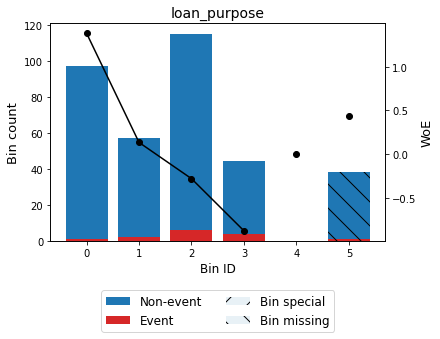

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[belanja online, biaya kesehatan, membayar hut...",97,0.276353,96,1,0.010309,1.383323,0.295253,0.034220
1,[renovasi rumah],57,0.162393,55,2,0.035088,0.13316,0.002709,0.000338
2,[modal usaha],115,0.327635,109,6,0.052174,-0.281437,0.029587,0.003686
3,"[biaya pendidikan, biaya liburan / umroh]",44,0.125356,40,4,0.090909,-0.878441,0.146717,0.017772
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,38,0.108262,37,1,0.026316,0.429892,0.016492,0.002046
Totals,,351,1.000000,337,14,0.039886,,0.490760,0.058062


[array(['belanja online', 'biaya kesehatan', 'membayar hutang lainnya',
        'membeli elektronik', 'membeli kendaraan',
        'transfer ke keluarga/teman', 'kebutuhan sehari-hari'],
       dtype=object),
 array(['renovasi rumah'], dtype=object),
 array(['modal usaha'], dtype=object),
 array(['biaya pendidikan', 'biaya liburan / umroh'], dtype=object),
 'Special',
 'Missing',
 '']

==
address_provinsi


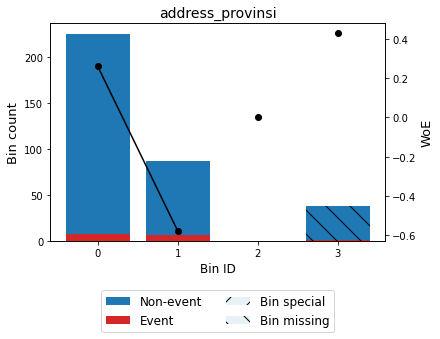

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[kepulauan riau, sumatera barat, sulawesi utar...",226,0.643875,219,7,0.030973,0.262136,0.039282,0.004896
1,"[dki jakarta, bali]",87,0.247863,81,6,0.068966,-0.578336,0.108852,0.013420
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,38,0.108262,37,1,0.026316,0.429892,0.016492,0.002046
Totals,,351,1.000000,337,14,0.039886,,0.164625,0.020362


[array(['kepulauan riau', 'sumatera barat', 'sulawesi utara',
        'sulawesi tenggara', 'sulawesi selatan', 'riau', 'papua barat',
        'papua', 'nanggroe aceh darussalam (nad)', 'maluku', 'lampung',
        'sumatera selatan', 'sumatera utara', 'kalimantan timur',
        'kalimantan selatan', 'kalimantan barat', 'jawa timur',
        'di yogyakarta', 'bengkulu', 'banten', 'kalimantan utara',
        'jawa tengah', 'jawa barat'], dtype=object),
 array(['dki jakarta', 'bali'], dtype=object),
 'Special',
 'Missing',
 '']

==
marital_status


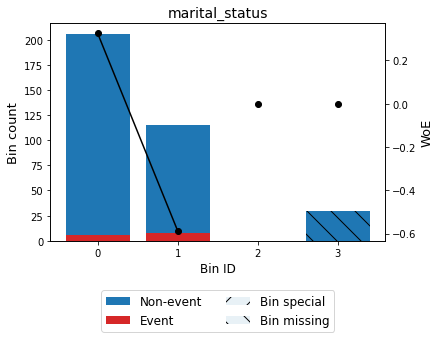

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[cerai, janda / duda, menikah]",206,0.586895,200,6,0.029126,0.325532,0.053680,0.006681
1,[lajang],115,0.327635,107,8,0.069565,-0.587638,0.149214,0.018388
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,30,0.085470,30,0,0.000000,0.0,0.000000,0.000000
Totals,,351,1.000000,337,14,0.039886,,0.202894,0.025068


[array(['cerai', 'janda / duda', 'menikah'], dtype=object),
 array(['lajang'], dtype=object),
 'Special',
 'Missing',
 '']

==
dependent


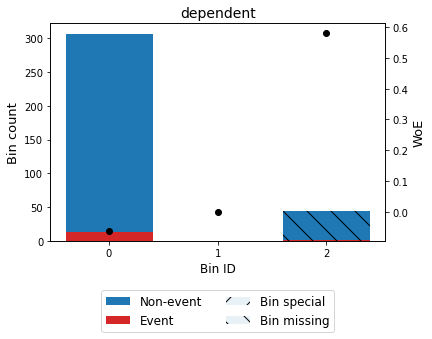

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",307,0.874644,294,13,0.042345,-0.062395,0.003505,0.000438
1,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
2,Missing,44,0.125356,43,1,0.022727,0.580175,0.032587,0.004017
Totals,,351,1.000000,337,14,0.039886,,0.036092,0.004455


['(-inf, inf)', 'Special', 'Missing', '']

==
job_type


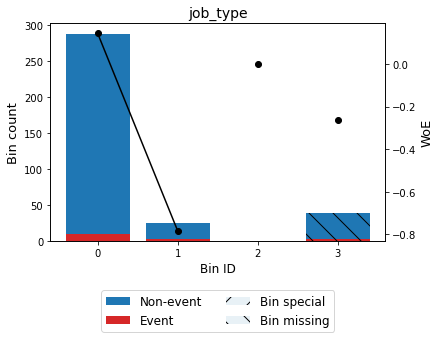

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[ibu rumah tangga, pengusaha, pegawai swasta]",288,0.820513,278,10,0.034722,0.14401,0.015933,0.001990
1,"[pegawai negeri, freelance]",24,0.068376,22,2,0.083333,-0.78313,0.060752,0.007406
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,39,0.111111,37,2,0.051282,-0.263255,0.008704,0.001085
Totals,,351,1.000000,337,14,0.039886,,0.085389,0.010481


[array(['ibu rumah tangga', 'pengusaha', 'pegawai swasta'], dtype=object),
 array(['pegawai negeri', 'freelance'], dtype=object),
 'Special',
 'Missing',
 '']

==
job_industry


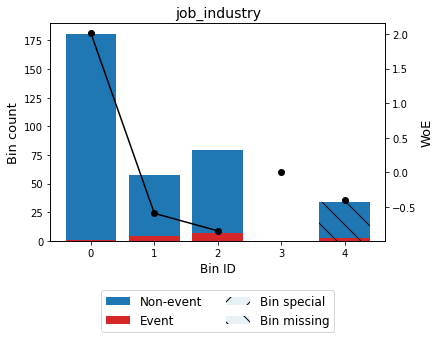

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[design / seni, hukum / security / politik, ko...",181,0.515670,180,1,0.005525,2.011931,0.930913,0.100012
1,[admin / finance / hr],57,0.162393,53,4,0.070175,-0.597028,0.076685,0.009446
2,"[pabrik / gudang, transportasi, entertainment ...",79,0.225071,72,7,0.088608,-0.85027,0.243475,0.029549
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,34,0.096866,32,2,0.058824,-0.408437,0.019565,0.002429
Totals,,351,1.000000,337,14,0.039886,,1.270637,0.141436


[array(['design / seni', 'hukum / security / politik',
        'konstruksi / real estate', 'pendidikan', 'perawatan tubuh',
        'perbankan', 'perhotelan', 'sales / marketing', 'service',
        'staf rumah tangga', 'tehnik / computer', 'kesehatan'],
       dtype=object),
 array(['admin / finance / hr'], dtype=object),
 array(['pabrik / gudang', 'transportasi', 'entertainment / event'],
       dtype=object),
 'Special',
 'Missing',
 '']

==
loan_amount


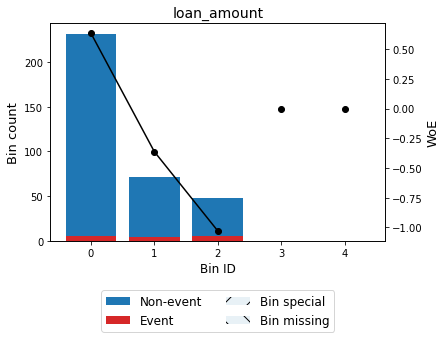

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2018903.00)",232,0.660969,227,5,0.021552,0.634487,0.200782,0.024685
1,"[2018903.00, 4125000.00)",71,0.202279,67,4,0.056338,-0.362627,0.031513,0.003918
2,"[4125000.00, inf)",48,0.136752,43,5,0.104167,-1.029263,0.236264,0.028295
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,351,1.000000,337,14,0.039886,,0.468558,0.056897


['(-inf, 2018903.00)',
 '[2018903.00, 4125000.00)',
 '[4125000.00, inf)',
 'Special',
 'Missing',
 '']

==
age


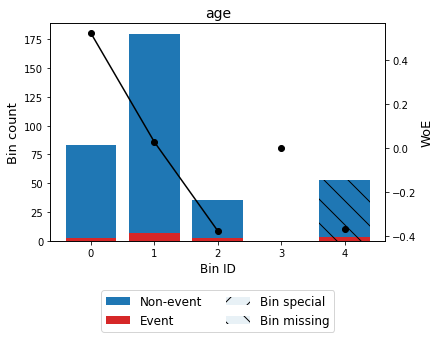

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 26.50)",83,0.236467,81,2,0.024096,0.520276,0.050726,0.006270
1,"[26.50, 41.50)",180,0.512821,173,7,0.038889,0.026356,0.000352,0.000044
2,"[41.50, inf)",35,0.099715,33,2,0.057143,-0.377665,0.016970,0.002109
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,53,0.150997,50,3,0.056604,-0.367615,0.024232,0.003012
Totals,,351,1.000000,337,14,0.039886,,0.092281,0.011435


['(-inf, 26.50)', '[26.50, 41.50)', '[41.50, inf)', 'Special', 'Missing', '']

==


In [30]:
binning_process_train = create_binning(
    train.drop(["application_id", "proba", "proba_bin",'customer_id','cdate','dob'], errors="ignore", axis=1),
    bfp,
    target="default",
)

Ensure that no NaN in application_id, loan_amount, and default

In [31]:
train.isna().any()

application_id      False
customer_id          True
loan_purpose         True
dob                  True
cdate                True
address_provinsi     True
marital_status       True
dependent            True
job_type             True
job_industry         True
loan_amount         False
default             False
age                  True
dtype: bool

In [32]:
train

,application_id,customer_id,loan_purpose,dob,cdate,address_provinsi,marital_status,dependent,job_type,job_industry,loan_amount,default,age
0,2004026292493,2003022998072,renovasi rumah,1995-02-05,2021-04-04 05:05:38.216675,jawa barat,lajang,0.0,pegawai swasta,sales / marketing,1300000,0,26
1,2004026597936,2003022469276,modal usaha,1999-06-02,2021-05-15 17:13:34.727932,jawa tengah,lajang,0.0,pegawai swasta,admin / finance / hr,619092,0,21
2,2004026763430,2003024104116,modal usaha,1992-11-27,2021-06-08 01:54:59.632958,jawa timur,lajang,0.0,pegawai swasta,entertainment / event,475568,0,28
3,2004025576523,2003023497984,None,1986-06-08,2020-12-16 04:07:36.680715,jawa timur,menikah,3.0,pengusaha,transportasi,1333333,0,34
4,2004026607585,2003022902253,modal usaha,1975-09-10,2021-05-17 09:05:09.015413,bali,menikah,NaN,pengusaha,sales / marketing,1333333,0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,2004026493724,2003023854943,renovasi rumah,1985-06-19,2021-04-29 10:26:48.076772,None,menikah,3.0,pegawai swasta,None,336700,0,35
347,2004026118497,2003023752181,biaya kesehatan,1999-10-29,2021-03-11 03:39:05.688931,jawa barat,lajang,0.0,pegawai swasta,tehnik / computer,471033,0,21
348,2004026451036,2003023920907,modal usaha,1988-03-01,2021-04-24 01:47:18.798512,bali,None,0.0,pegawai swasta,admin / finance / hr,500000,0,33
349,2004026086034,2003022115942,renovasi rumah,1989-01-14,2021-03-06 10:05:59.841948,dki jakarta,menikah,1.0,pegawai swasta,service,1545454,0,32


In [33]:
# train=dfwow2
# valid=dfwow2

y_train = train.default
y_valid = valid.default
X_train = binning_process_train.transform(train.drop(columns=["default"]))
X_valid = binning_process_train.transform(valid.drop(columns=["default",]))

# X_train=X_train.reset_index()
# X_train['loan_amount']=train['loan_amount']
# # X_valid=X_valid.reset_index()
# X_valid['loan_amount']=valid['loan_amount']

In [34]:
X_train.head()

,loan_purpose,address_provinsi,marital_status,dependent,job_type,job_industry,loan_amount,age
0,0.133160,0.262136,-0.587638,-0.062395,0.14401,2.011931,0.634487,0.520276
1,-0.281437,0.262136,-0.587638,-0.062395,0.14401,-0.597028,0.634487,0.520276
2,-0.281437,0.262136,-0.587638,-0.062395,0.14401,-0.850270,0.634487,0.026356
3,0.000000,0.262136,0.325532,-0.062395,0.14401,-0.850270,0.634487,0.026356
4,-0.281437,-0.578336,0.325532,0.000000,0.14401,2.011931,0.634487,-0.377665


In [35]:
class_weight = get_class_weight(train)
class_weight

{0: 0.03988603988603989, 1: 0.9601139601139601}

Here are the description of IV in Naeem Siddiqi's book

In [36]:
get_iv(binning_process_train)

,column,IV,predictiveness
5,job_industry,1.270637,Suspicious Predictive Power
0,loan_purpose,0.490760,Strong predictive Power
6,loan_amount,0.468558,Strong predictive Power
2,marital_status,0.202894,Medium predictive Power
1,address_provinsi,0.164625,Medium predictive Power
7,age,0.092281,Weak predictive Power
4,job_type,0.085389,Weak predictive Power
3,dependent,0.036092,Weak predictive Power


In [37]:
X_train.shape

(351, 8)

In [38]:
lrtrain = LogisticRegression(
    n_jobs=-1,
    class_weight=class_weight
    # class_weight='balanced'
)
lrtrain.fit(X_train, y_train)
train_proba = lrtrain.predict_proba(X_train)[:, 1]
train_pred = lrtrain.predict(X_train)
valid_pred = lrtrain.predict(X_valid)
valid_proba = lrtrain.predict_proba(X_valid)[:, 1]

#### \2. Which metrics do you use? and why? 

- AUC: to measure the ability of a classifier to distinguish between classes
- KS: to discriminate between good” and “bad” customers, by comparing the distribution between “good” customers and “bad” customers. 
- Recall: because false negatives (bad borrowers who are misclassified as good) are much more harmful than false positives (good borrowers who are misclassified as bad)
- F1: because even when false negative is more harmful, we still need to have a nice metric between precision and recall



precision=0.5447530864197531
recall=0.7489402289105553
fscore=0.5039570378745053


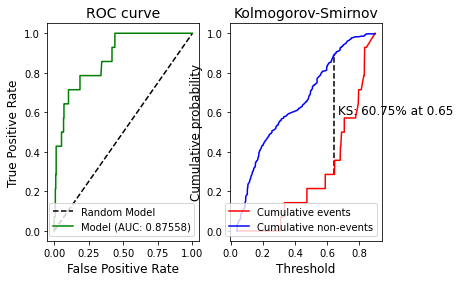

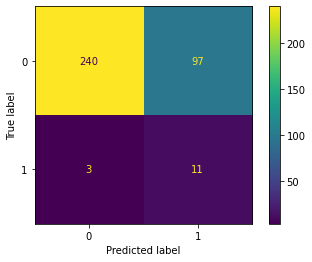

In [39]:
plt.subplot(1, 2, 1)
plot_auc_roc(y_train, train_proba)
plt.subplot(1, 2, 2)
plot_ks(y_train, train_proba)

precision, recall, fscore, support = precision_recall_fscore_support(
    y_train, train_pred, average="macro"
)
print(
    f"""precision={precision}
recall={recall}
fscore={fscore}"""
)
ConfusionMatrixDisplay.from_estimator(lrtrain, X_train, y_train)

precision=0.5148162040510128
recall=0.5705357142857144
fscore=0.4747474747474747


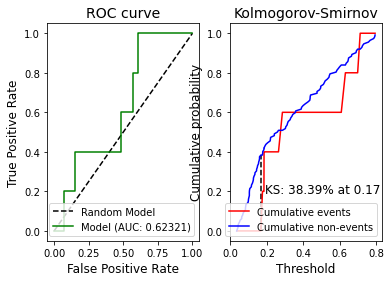

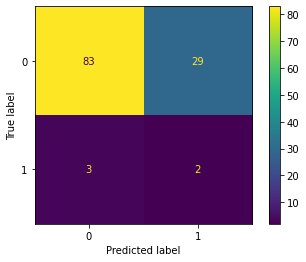

In [40]:
plt.subplot(1, 2, 1)
plot_auc_roc(y_valid, valid_proba)
plt.subplot(1, 2, 2)
plot_ks(y_valid, valid_proba)

precision, recall, fscore, support = precision_recall_fscore_support(
    y_valid, valid_pred, average="macro"
)
print(
    f"""precision={precision}
recall={recall}
fscore={fscore}"""
)
ConfusionMatrixDisplay.from_estimator(lrtrain, X_valid, y_valid)

#### \3. Explain why your model can be considered as good enough.

Actually the model is not good yet. Need to spend more time on collecting more data on defaulters and creating more better features. The model can be considered as good enough if getting the better AUC  and K-S higher than banks since P2P Lending have more risks than banks

#### \4. How can the business use the model?

The model could be used for application scoring, by predicting which users are approved of loan.

Risky applicants (risky deciles) could be rejected of loan, or approved but with reduced approved_credits.


##### All data

In [41]:
dfnew2 = dfnew.copy().drop(["proba", "cumdefault"], errors="ignore", axis=1)
X = dfnew2.drop("default", axis=1)
y = dfnew2.default

In [42]:
bfp.pop("application_id")

{'dtype': 'numerical', 'solver': 'cp'}

In [43]:
bfp

{'customer_id': {'dtype': 'numerical', 'solver': 'cp'},
 'loan_purpose': {'dtype': 'categorical', 'solver': 'cp'},
 'dob': {'dtype': 'numerical', 'solver': 'cp'},
 'cdate': {'dtype': 'numerical', 'solver': 'cp'},
 'address_provinsi': {'dtype': 'categorical', 'solver': 'cp'},
 'marital_status': {'dtype': 'categorical', 'solver': 'cp'},
 'dependent': {'dtype': 'numerical',
  'solver': 'cp',
  'monotonic_trend': 'ascending'},
 'job_type': {'dtype': 'categorical', 'solver': 'cp'},
 'job_industry': {'dtype': 'categorical', 'solver': 'cp'},
 'loan_amount': {'dtype': 'numerical',
  'solver': 'cp',
  'monotonic_trend': 'ascending'},
 'default': {'dtype': 'numerical', 'solver': 'cp'},
 'age': {'dtype': 'numerical',
  'solver': 'cp',
  'monotonic_trend': 'auto_asc_desc'}}

tes tes
list_features=['loan_purpose' 'address_provinsi' 'marital_status' 'dependent' 'job_type'
 'job_industry' 'loan_amount' 'age']
loan_purpose


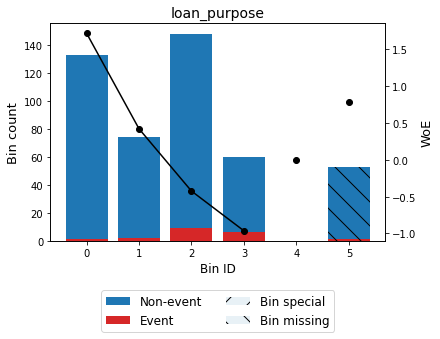

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[belanja online, biaya kesehatan, membayar hut...",133,0.284188,132,1,0.007519,1.720218,0.415183,0.046318
1,[renovasi rumah],74,0.158120,72,2,0.027027,0.420935,0.023191,0.002878
2,[modal usaha],148,0.316239,139,9,0.060811,-0.425335,0.069801,0.008660
3,"[biaya pendidikan, biaya liburan / umroh]",60,0.128205,54,6,0.100000,-0.965359,0.188749,0.022718
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,53,0.113248,52,1,0.018868,0.78866,0.049829,0.006072
Totals,,468,1.000000,449,19,0.040598,,0.746752,0.086645


[array(['belanja online', 'biaya kesehatan', 'membayar hutang lainnya',
        'membeli elektronik', 'membeli kendaraan',
        'transfer ke keluarga/teman', 'kebutuhan sehari-hari'],
       dtype=object),
 array(['renovasi rumah'], dtype=object),
 array(['modal usaha'], dtype=object),
 array(['biaya pendidikan', 'biaya liburan / umroh'], dtype=object),
 'Special',
 'Missing',
 '']

==
address_provinsi


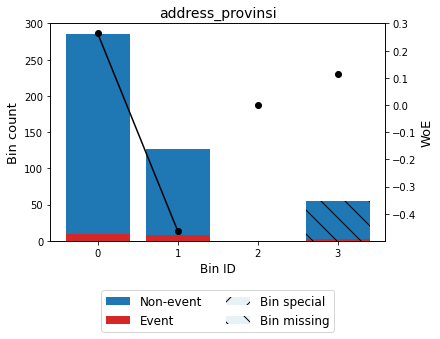

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[kalimantan utara, sumatera barat, sulawesi ut...",286,0.611111,277,9,0.031469,0.264209,0.037846,0.004717
1,"[dki jakarta, bali, kalimantan timur]",127,0.271368,119,8,0.062992,-0.462902,0.072222,0.008948
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,55,0.117521,53,2,0.036364,0.114561,0.001464,0.000183
Totals,,468,1.000000,449,19,0.040598,,0.111531,0.013848


[array(['kalimantan utara', 'sumatera barat', 'sulawesi utara',
        'sulawesi tenggara', 'sulawesi selatan', 'riau', 'papua barat',
        'papua', 'nanggroe aceh darussalam (nad)', 'maluku', 'lampung',
        'kepulauan riau', 'sumatera utara', 'kalimantan tengah',
        'kalimantan selatan', 'kalimantan barat', 'di yogyakarta',
        'bengkulu', 'banten', 'sumatera selatan', 'jawa timur',
        'jawa barat', 'jawa tengah'], dtype=object),
 array(['dki jakarta', 'bali', 'kalimantan timur'], dtype=object),
 'Special',
 'Missing',
 '']

==
marital_status


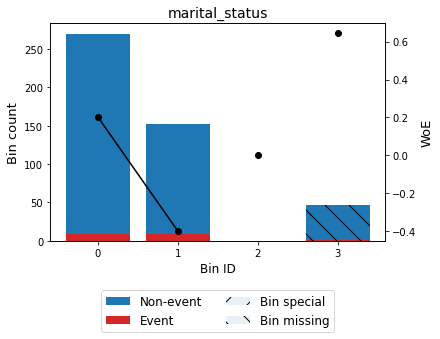

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[cerai, janda / duda, menikah]",270,0.576923,261,9,0.033333,0.204712,0.022029,0.002749
1,[lajang],152,0.324786,143,9,0.059211,-0.396964,0.061608,0.007651
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,46,0.098291,45,1,0.021739,0.644079,0.030652,0.003767
Totals,,468,1.000000,449,19,0.040598,,0.114289,0.014166


[array(['cerai', 'janda / duda', 'menikah'], dtype=object),
 array(['lajang'], dtype=object),
 'Special',
 'Missing',
 '']

==
dependent


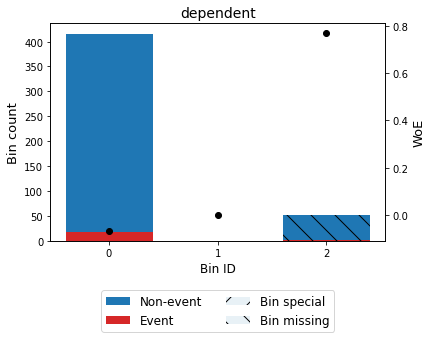

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",416,0.888889,398,18,0.043269,-0.066504,0.004054,0.000507
1,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
2,Missing,52,0.111111,51,1,0.019231,0.769242,0.046888,0.005721
Totals,,468,1.000000,449,19,0.040598,,0.050942,0.006227


['(-inf, inf)', 'Special', 'Missing', '']

==
job_type


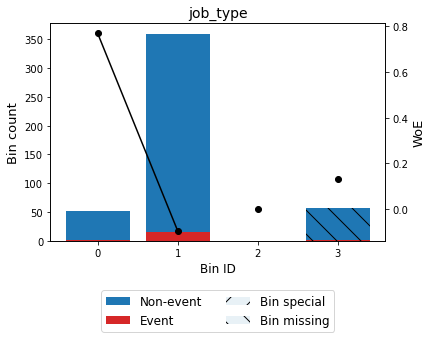

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[ibu rumah tangga, pengusaha, pegawai negeri]",52,0.111111,51,1,0.019231,0.769242,0.046888,0.005721
1,"[pegawai swasta, freelance]",360,0.769231,344,16,0.044444,-0.094531,0.007180,0.000897
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,56,0.119658,54,2,0.035714,0.133253,0.001999,0.000250
Totals,,468,1.000000,449,19,0.040598,,0.056068,0.006868


[array(['ibu rumah tangga', 'pengusaha', 'pegawai negeri'], dtype=object),
 array(['pegawai swasta', 'freelance'], dtype=object),
 'Special',
 'Missing',
 '']

==
job_industry


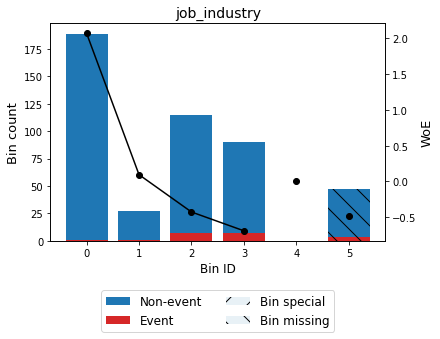

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[design / seni, pendidikan, perawatan tubuh, p...",189,0.403846,188,1,0.005291,2.073858,0.759191,0.080874
1,[kesehatan],27,0.057692,26,1,0.037037,0.095513,0.000504,0.000063
2,"[perbankan, pabrik / gudang, transportasi]",115,0.245726,108,7,0.060870,-0.426363,0.054526,0.006765
3,"[admin / finance / hr, hukum / security / poli...",90,0.192308,83,7,0.077778,-0.689653,0.126597,0.015518
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,47,0.100427,44,3,0.063830,-0.477007,0.028572,0.003538
Totals,,468,1.000000,449,19,0.040598,,0.969390,0.106758


[array(['design / seni', 'pendidikan', 'perawatan tubuh', 'perhotelan',
        'sales / marketing', 'service', 'staf rumah tangga',
        'tehnik / computer', 'konstruksi / real estate'], dtype=object),
 array(['kesehatan'], dtype=object),
 array(['perbankan', 'pabrik / gudang', 'transportasi'], dtype=object),
 array(['admin / finance / hr', 'hukum / security / politik',
        'entertainment / event'], dtype=object),
 'Special',
 'Missing',
 '']

==
loan_amount


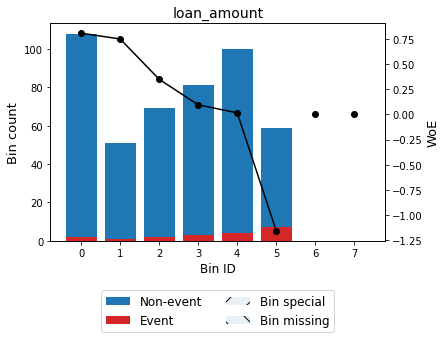

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 505290.50)",108,0.230769,106,2,0.018519,0.807708,0.105662,0.012860
1,"[505290.50, 804986.50)",51,0.108974,50,1,0.019608,0.749439,0.044012,0.005376
2,"[804986.50, 1234513.00)",69,0.147436,67,2,0.028986,0.348962,0.015339,0.001908
3,"[1234513.00, 2078157.00)",81,0.173077,78,3,0.037037,0.095513,0.001511,0.000189
4,"[2078157.00, 4437500.00)",100,0.213675,96,4,0.040000,0.01547,0.000051,0.000006
5,"[4437500.00, inf)",59,0.126068,52,7,0.118644,-1.15725,0.292331,0.034630
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,468,1.000000,449,19,0.040598,,0.458907,0.054969


['(-inf, 505290.50)',
 '[505290.50, 804986.50)',
 '[804986.50, 1234513.00)',
 '[1234513.00, 2078157.00)',
 '[2078157.00, 4437500.00)',
 '[4437500.00, inf)',
 'Special',
 'Missing',
 '']

==
age


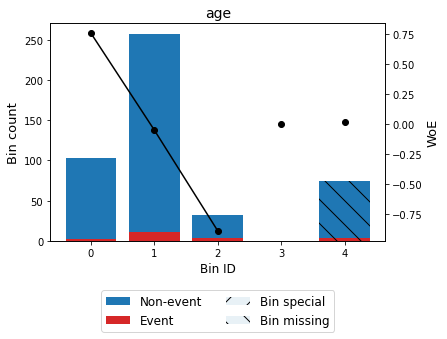

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 26.50)",103,0.220085,101,2,0.019417,0.759389,0.090885,0.011095
1,"[26.50, 44.50)",258,0.551282,247,11,0.042636,-0.051091,0.001473,0.000184
2,"[44.50, inf)",32,0.068376,29,3,0.093750,-0.8939,0.083407,0.010092
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,75,0.160256,72,3,0.040000,0.01547,0.000038,0.000005
Totals,,468,1.000000,449,19,0.040598,,0.175803,0.021376


['(-inf, 26.50)', '[26.50, 44.50)', '[44.50, inf)', 'Special', 'Missing', '']

==


In [44]:
binning_process_all = create_binning(
    dfnew2.drop(["application_id",'customer_id','cdate','dob'], axis=1),
    bfp,
    target="default",
)

In [45]:
from optbinning.binning import binning_process

Xtr = binning_process_all.transform(X)

In [46]:
Xtr.head()

,loan_purpose,address_provinsi,marital_status,dependent,job_type,job_industry,loan_amount,age
0,-0.425335,0.264209,-0.396964,-0.066504,-0.094531,-0.689653,0.807708,0.759389
1,-0.425335,0.264209,0.204712,-0.066504,-0.094531,-0.689653,0.095513,-0.051091
2,1.720218,0.000000,-0.396964,-0.066504,-0.094531,-0.426363,-1.157250,0.000000
3,-0.425335,0.264209,0.204712,-0.066504,-0.094531,-0.426363,0.095513,0.759389
4,0.420935,0.000000,0.000000,-0.066504,-0.094531,2.073858,-1.157250,-0.051091


In [47]:
lrall = LogisticRegression(
    n_jobs=-1,
    class_weight=class_weight
    # class_weight='balanced'
)
lrall.fit(Xtr, y)
all_proba=lrall.predict_proba(Xtr).T[1]


In [48]:

dfnew2 = dfnew
dfnew2["proba"] = all_proba
dfnew2["proba_bin"] = pd.qcut(dfnew2.proba, 10)
dfnew2=dfnew2.set_index("proba_bin")
default_rate_decile = dfnew2.groupby("proba_bin").default.mean()
# display(default_rate_decile.reset_index())

dfnew2["default_rate_decile"] = dfnew2.groupby("proba_bin").default.mean()
dfnew2=dfnew2.reset_index(drop=True)

dfnew2["proba_bin"] = pd.qcut(dfnew2.proba, 10)


dfnew2 = dfnew2.sort_values("proba")
dfnew2["_defaultcumsum"] = dfnew2.default.cumsum()  # + dfnew2['default']
dfnew2["_ones"] = 1
dfnew2["_onescumsum"] = dfnew2["_ones"].cumsum()
dfnew2["cum_default_rate"] = dfnew2["_defaultcumsum"] / dfnew2["_onescumsum"]
# dfnew2

# print("hampir")
# hampir=dfnew2[dfnew2.cum_default_rate<=0.02].tail(1).copy()
# display(hampir)


# dfnew2
# hampir['loan_amount']=2078157
# (lrall.predict_proba(binning_process_train.transform(lewatdikit)))[0][1]
# ob=binning_process_train.get_binned_variable('loan_amount')
# ob.binning_table.build()

In [49]:
display("default rate per decile")
display(default_rate_decile.reset_index())
dfnew2

'default rate per decile'

,proba_bin,default
0,"(0.017599999999999998, 0.0781]",0.000000
1,"(0.0781, 0.125]",0.000000
2,"(0.125, 0.172]",0.000000
3,"(0.172, 0.22]",0.000000
4,"(0.22, 0.285]",0.000000
5,"(0.285, 0.402]",0.063830
6,"(0.402, 0.505]",0.000000
7,"(0.505, 0.592]",0.065217
8,"(0.592, 0.684]",0.042553
9,"(0.684, 0.92]",0.234043


,application_id,customer_id,loan_purpose,dob,cdate,address_provinsi,marital_status,dependent,job_type,job_industry,loan_amount,default,age,proba,default_rate_decile,proba_bin,_defaultcumsum,_ones,_onescumsum,cum_default_rate
422,2004026887205,2003024182303,kebutuhan sehari-hari,1995-11-24,2021-06-25 11:49:15.152680,jawa barat,menikah,NaN,pegawai swasta,sales / marketing,666666,0,25,0.018603,0.000000,"(0.017599999999999998, 0.0781]",0,1,1,0.000000
383,2004026699875,2003023950141,belanja online,1978-08-05,2021-05-30 22:11:06.005066,di yogyakarta,menikah,2.0,pengusaha,service,107914,0,42,0.018782,0.000000,"(0.017599999999999998, 0.0781]",0,1,2,0.000000
325,2004026717006,2003022279780,kebutuhan sehari-hari,1997-09-09,2021-06-02 03:07:19.467799,None,menikah,1.0,pegawai swasta,sales / marketing,543559,0,23,0.020484,0.000000,"(0.017599999999999998, 0.0781]",0,1,3,0.000000
447,2004027142844,2003023807947,kebutuhan sehari-hari,2000-08-01,2021-08-03 00:27:10.613477,banten,lajang,0.0,None,sales / marketing,500000,0,21,0.025095,0.000000,"(0.017599999999999998, 0.0781]",0,1,4,0.000000
466,2004026118497,2003023752181,biaya kesehatan,1999-10-29,2021-03-11 03:39:05.688931,jawa barat,lajang,0.0,pegawai swasta,tehnik / computer,471033,0,21,0.026273,0.000000,"(0.017599999999999998, 0.0781]",0,1,5,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2004026510060,2003023954221,biaya pendidikan,1974-04-17,2021-05-01 23:12:05.376727,dki jakarta,menikah,1.0,pegawai swasta,hukum / security / politik,2400000,0,47,0.865941,0.234043,"(0.684, 0.92]",16,1,464,0.034483
15,2004028143024,2003022410749,biaya pendidikan,1972-07-28,2021-11-09 08:17:38.504584,jawa barat,menikah,3.0,pegawai negeri,admin / finance / hr,18000000,1,49,0.870279,0.234043,"(0.684, 0.92]",17,1,465,0.036559
132,2004026994834,2003024251111,biaya pendidikan,1980-09-12,2021-07-11 11:02:48.721440,dki jakarta,menikah,NaN,None,admin / finance / hr,6000000,1,40,0.886485,0.234043,"(0.684, 0.92]",18,1,466,0.038627
8,2004025708676,2003022313019,biaya pendidikan,1974-11-03,2021-01-10 08:38:49.024720,banten,menikah,3.0,pegawai swasta,pabrik / gudang,5750000,0,46,0.893581,0.234043,"(0.684, 0.92]",18,1,467,0.038544


#### \5. Could you provide which customers/loan we should avoid? Why?

Yes, using the model, we could return the list of probability of the applications. Which later can we use to make approval decision based on threshold/cutoff or risk grade

In [50]:
# dfnew2.proba_bin

In [51]:
print("lewat dikit")
lewatdikit = dfnew2[dfnew2.cum_default_rate >= 0.02].head(1).copy()
display(lewatdikit)

lewat dikit


,application_id,customer_id,loan_purpose,dob,cdate,address_provinsi,marital_status,dependent,job_type,job_industry,loan_amount,default,age,proba,default_rate_decile,proba_bin,_defaultcumsum,_ones,_onescumsum,cum_default_rate
231,2004027223683,2003022586198,modal usaha,2000-08-13,NaT,jawa barat,lajang,0.0,pegawai swasta,pabrik / gudang,1628571,1,<NA>,0.69252,0.234043,"(0.684, 0.92]",9,1,425,0.021176


In [52]:
# dfnew2.groupby("proba_bin").default.mean()

#### \6. If the business would like to achieve 2% cumulative default rate, which loans should we accept?

Provided below. Here are the list where cumulative default rate is <2%

In [53]:
accepted = dfnew2[dfnew2.proba < lewatdikit.iloc[0].proba]
accepted

,application_id,customer_id,loan_purpose,dob,cdate,address_provinsi,marital_status,dependent,job_type,job_industry,loan_amount,default,age,proba,default_rate_decile,proba_bin,_defaultcumsum,_ones,_onescumsum,cum_default_rate
422,2004026887205,2003024182303,kebutuhan sehari-hari,1995-11-24,2021-06-25 11:49:15.152680,jawa barat,menikah,NaN,pegawai swasta,sales / marketing,666666,0,25,0.018603,0.000000,"(0.017599999999999998, 0.0781]",0,1,1,0.000000
383,2004026699875,2003023950141,belanja online,1978-08-05,2021-05-30 22:11:06.005066,di yogyakarta,menikah,2.0,pengusaha,service,107914,0,42,0.018782,0.000000,"(0.017599999999999998, 0.0781]",0,1,2,0.000000
325,2004026717006,2003022279780,kebutuhan sehari-hari,1997-09-09,2021-06-02 03:07:19.467799,None,menikah,1.0,pegawai swasta,sales / marketing,543559,0,23,0.020484,0.000000,"(0.017599999999999998, 0.0781]",0,1,3,0.000000
447,2004027142844,2003023807947,kebutuhan sehari-hari,2000-08-01,2021-08-03 00:27:10.613477,banten,lajang,0.0,None,sales / marketing,500000,0,21,0.025095,0.000000,"(0.017599999999999998, 0.0781]",0,1,4,0.000000
466,2004026118497,2003023752181,biaya kesehatan,1999-10-29,2021-03-11 03:39:05.688931,jawa barat,lajang,0.0,pegawai swasta,tehnik / computer,471033,0,21,0.026273,0.000000,"(0.017599999999999998, 0.0781]",0,1,5,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2004026680041,2003022670017,biaya pendidikan,1991-03-01,2021-05-28 06:32:40.081538,dki jakarta,menikah,1.0,pegawai swasta,kesehatan,2500000,0,30,0.681199,0.042553,"(0.592, 0.684]",8,1,420,0.019048
265,2004027287386,2003024307840,modal usaha,1993-10-29,2021-08-21 22:24:11.744124,dki jakarta,menikah,1.0,pegawai swasta,admin / finance / hr,1166666,0,27,0.682695,0.042553,"(0.592, 0.684]",8,1,421,0.019002
295,2004025871252,2003023629251,modal usaha,1972-06-10,2021-02-05 07:29:21.935138,dki jakarta,menikah,2.0,pengusaha,pabrik / gudang,1875000,0,48,0.685986,0.234043,"(0.684, 0.92]",8,1,422,0.018957
68,2004026686912,2003023017678,None,1992-08-18,2021-05-29 04:30:36.111249,sumatera utara,lajang,0.0,pegawai swasta,admin / finance / hr,3333333,0,28,0.686481,0.234043,"(0.684, 0.92]",8,1,423,0.018913


Bonus: if the business want to accept more than 424 users, we can accept more customer by lowering the loan_amount of the risky deciles/customers above the threshold. See the `new_loan_amount` column in the most bottom cells. Here are a rough example:

In [54]:
proba_max = accepted.tail(1).iloc[0].proba
proba_max

0.691316466034131

In [55]:
binloan=binning_process_all.get_binned_variable('loan_amount')
thebin=binloan.binning_table.build().Bin.values[:-3].tolist()
binlist=[0]+[float(s.split(', ')[1][:-1]) for s in thebin]
binlist

[0, 505290.5, 804986.5, 1234513.0, 2078157.0, 4437500.0, inf]

In [56]:
rejected=dfnew2[dfnew2.proba > proba_max]
rejected

,application_id,customer_id,loan_purpose,dob,cdate,address_provinsi,marital_status,dependent,job_type,job_industry,loan_amount,default,age,proba,default_rate_decile,proba_bin,_defaultcumsum,_ones,_onescumsum,cum_default_rate
231,2004027223683,2003022586198,modal usaha,2000-08-13,NaT,jawa barat,lajang,0.0,pegawai swasta,pabrik / gudang,1628571,1,<NA>,0.692520,0.234043,"(0.684, 0.92]",9,1,425,0.021176
432,2004026515566,2003023566840,renovasi rumah,1993-03-09,2021-05-02 22:13:36.553205,jawa tengah,menikah,1.0,pegawai swasta,admin / finance / hr,9000000,0,28,0.693839,0.234043,"(0.684, 0.92]",9,1,426,0.021127
94,2004026259450,2003021661444,renovasi rumah,1986-11-02,2021-03-29 08:53:15.867666,banten,menikah,0.0,pegawai swasta,admin / finance / hr,8100000,0,34,0.693839,0.234043,"(0.684, 0.92]",9,1,427,0.021077
461,2004025647365,2003022681775,modal usaha,1993-11-09,2020-12-30 02:23:24.262759,banten,lajang,0.0,pegawai swasta,pabrik / gudang,1277777,0,27,0.698845,0.234043,"(0.684, 0.92]",9,1,428,0.021028
125,2004026637283,2003023942054,biaya pendidikan,1985-12-21,2021-05-22 01:25:42.361634,jawa barat,menikah,3.0,pegawai swasta,pabrik / gudang,1500000,0,35,0.701204,0.234043,"(0.684, 0.92]",9,1,429,0.020979
409,2004025974960,2003023679997,biaya pendidikan,1977-06-02,2021-02-19 13:51:14.075758,jawa barat,menikah,NaN,None,pabrik / gudang,3125000,0,43,0.701326,0.234043,"(0.684, 0.92]",9,1,430,0.020930
49,2004027202280,2003024380540,modal usaha,1995-05-05,2021-08-11 07:09:44.810136,None,menikah,1.0,pegawai swasta,pabrik / gudang,7000000,0,26,0.702381,0.234043,"(0.684, 0.92]",9,1,431,0.020882
244,2004026314580,2003023849546,modal usaha,1999-10-02,NaT,banten,lajang,0.0,pegawai swasta,pabrik / gudang,3150000,0,<NA>,0.703056,0.234043,"(0.684, 0.92]",9,1,432,0.020833
278,2004025892645,2003020680474,modal usaha,1993-11-17,2021-02-08 01:29:15.754767,dki jakarta,lajang,0.0,pegawai swasta,admin / finance / hr,83416,0,27,0.704109,0.234043,"(0.684, 0.92]",9,1,433,0.020785
114,2004026432024,2003023910062,biaya liburan / umroh,1989-07-07,NaT,jawa barat,menikah,2.0,pegawai swasta,hukum / security / politik,1000000,0,<NA>,0.704881,0.234043,"(0.684, 0.92]",9,1,434,0.020737


In [57]:
rejected['new_loan_amount']=rejected.loan_amount.apply(lambda oldloan:  max([b for b in binlist if b <= oldloan]))

C:\Users\mrlut\AppData\Local\Temp/ipykernel_1912/761914720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejected['new_loan_amount']=rejected.loan_amount.apply(lambda oldloan:  max([b for b in binlist if b <= oldloan]))


In [58]:
rejected[['application_id','loan_amount','new_loan_amount']]

,application_id,loan_amount,new_loan_amount
231,2004027223683,1628571,1234513.0
432,2004026515566,9000000,4437500.0
94,2004026259450,8100000,4437500.0
461,2004025647365,1277777,1234513.0
125,2004026637283,1500000,1234513.0
409,2004025974960,3125000,2078157.0
49,2004027202280,7000000,4437500.0
244,2004026314580,3150000,2078157.0
278,2004025892645,83416,0.0
114,2004026432024,1000000,804986.5


### Assignment 6 - Further Improvement

If you have had more time, what would you recommend to further improve the model and why?

- create better features
- more rigorous model testing
- remove unsignificant feature
- create behavior scoring model using payment data

## Assignment 7
At JULO, we have 6 values that we follow, that are following our two core values:

![6 Core Values](julo_values.png)

A. Please choose three Core Values from the 6 values above that you think is your strength, share us one specific example where you showed it

1. we are diligent in our work and aim for the highest quality
2. we work hard are productive and consistently deliver value to the business
3. We contribute to a collaborative, positive, supportive and healthy environment in which we can succeed together

example

1. I do things in highest quality and not cutting corners
2. I get things done and always communicate with stakeholder
3. I strive to help my team when they have trouble and sharing my knowledge 

B. Please choose three Core Values from the 6 values above that you think is your weakness, share us one specific example where you showed it

1. we challenge each others ideas, but we respect each other opinions
2. We communicate honestly and directly
3. We are critical and rigorous in our assessment. Good ideas will stand to scrutiny

reason: I am afraid to argue with other people so I don't hurt their feelings, this is the area I am planning to improve on


C. Please order the 6 Core Values based on your priority if you work at JULO and why 

1. We care deeply about our company mission, colleagues, and customers
2. we are diligent in our work and aim for the highest quality
3. We raise the bar, continuously learn and improve our work and ourselves.
4. We contribute to a collaborative, positive, supportive and healthy environment in which we can succeed together
5. We communicate honestly and directly
6. we do not tolerate discrimination and harrassment


reasons
1. I want to deliver what best for our users
2. We do things excellently so we can be proud of our own work
3. I want to grow and be the expert, together with my colleagues at JULO
4. I want to create environment that all of us can grow together
5. With honesty and transparency, I want to deliver what's best and be the best version of ourselves
6. I believe everybody are same, has the same potential, and should not face any kind of harrassment 